In [2]:
import pandas as pd
import numpy as np 
import xgboost as xgb 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [3]:
train_labels = pd.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv')
train_labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [4]:
train_labels['customer_ID'].nunique() , train_labels['customer_ID'].duplicated().any()

(458913, False)

In [5]:
(train_labels['target'].value_counts()/len(train_labels))*100

0    74.106639
1    25.893361
Name: target, dtype: float64

Insights :

*1. Accuracy will not be a good metric .*    
*2. During Cross Validation , StratifiedKFold will be used.*

In [6]:
%%time
traindata = pd.read_feather('/kaggle/input/amexfeather/train_data.ftr')
testdata = pd.read_feather('/kaggle/input/amexfeather/test_data.ftr')

display(traindata.head())

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


CPU times: user 17.5 s, sys: 11.8 s, total: 29.3 s
Wall time: 1min 7s


In [7]:
traindata.shape , testdata.shape

((5531451, 191), (11363762, 190))

In [8]:
traindata.info(max_cols = 200 , show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

In [9]:
traindata['customer_ID'].nunique()

458913

**STATEMENT ISSUE DATE** 

In [10]:
max_date = traindata['S_2'].max()
min_date = traindata['S_2'].min()

print("Train dates are : " , max_date , min_date , traindata['S_2'].isna().any())
print("Test dates are : " , testdata['S_2'].max() , testdata['S_2'].min() , testdata['S_2'].isna().any())

Train dates are :  2018-03-31 00:00:00 2017-03-01 00:00:00 False
Test dates are :  2019-10-31 00:00:00 2018-04-01 00:00:00 False


Insight:

*Our model will not be able to take into account if any economic mishappening occurs in the future* 

In [11]:
traincustomer_dates = traindata.groupby(['customer_ID'])['S_2'].agg(['max','min','count'])
traincustomer_dates.reset_index(inplace = True)

In [12]:
traincustomer_dates.head()

,customer_ID,max,min,count
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,2017-03-09,13
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,2017-03-01,13
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,2017-03-11,13
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-29,2017-03-31,13
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-30,2017-03-30,13


In [13]:
traincustomer_dates['count'].unique()

array([13,  3,  4,  9, 12,  8,  2, 10,  1,  7,  6, 11,  5])

In [14]:
testcustomer_dates = testdata.groupby(['customer_ID'])['S_2'].agg(['max','min','count'])
testcustomer_dates.reset_index(inplace = True)

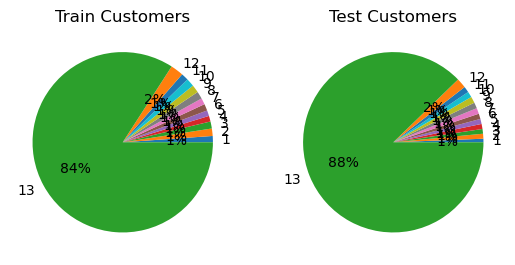

In [15]:
x = traincustomer_dates['count'].value_counts().sort_index(ascending = True)
y = testcustomer_dates['count'].value_counts().sort_index(ascending = True)
 
labels = x.index 
values = x.values

labels_2 = y.index 
values_2 = y.values

fig , ax = plt.subplots(1,2)
axes = ax.flatten()
axes[0].pie(values , labels = labels , autopct = '%.0f%%')
axes[0].set_title('Train Customers')

axes[1].pie(values_2 , labels = labels_2 , autopct = '%.0f%%')
axes[1].set_title('Test Customers')
plt.show()

In [16]:
traincustomer_dates['days'] = (traincustomer_dates['max']-traincustomer_dates['min']).dt.days
traincustomer_dates.head()

,customer_ID,max,min,count,days
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,2017-03-09,13,369
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,2017-03-01,13,389
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,2017-03-11,13,366
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-29,2017-03-31,13,363
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-30,2017-03-30,13,365


<Axes: xlabel='days', ylabel='Count'>

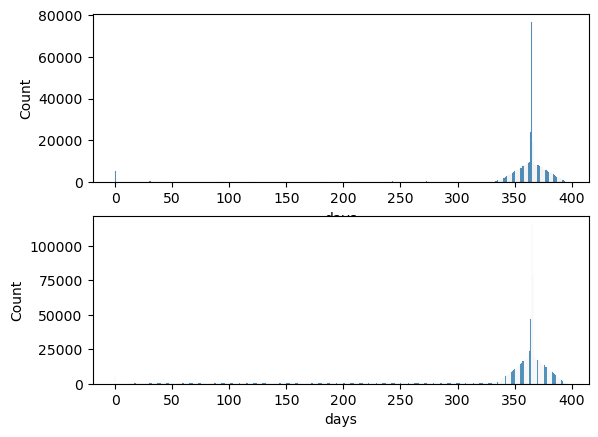

In [17]:
testcustomer_dates['days'] = (testcustomer_dates['max']-testcustomer_dates['min']).dt.days

fig , axes = plt.subplots(2,1)
axes = axes.flatten()

sns.histplot(data = traincustomer_dates , x = 'days' , ax = axes[0])
sns.histplot(data = testcustomer_dates , x = 'days' , ax = axes[1])

In [18]:
data = traincustomer_dates.groupby('max')['customer_ID'].count().reset_index().rename(columns = {'Count' : 'customer_ID'})
data.head()

,max,customer_ID
0,2018-03-01,12128
1,2018-03-02,10562
2,2018-03-03,22887
3,2018-03-04,8918
4,2018-03-05,10081


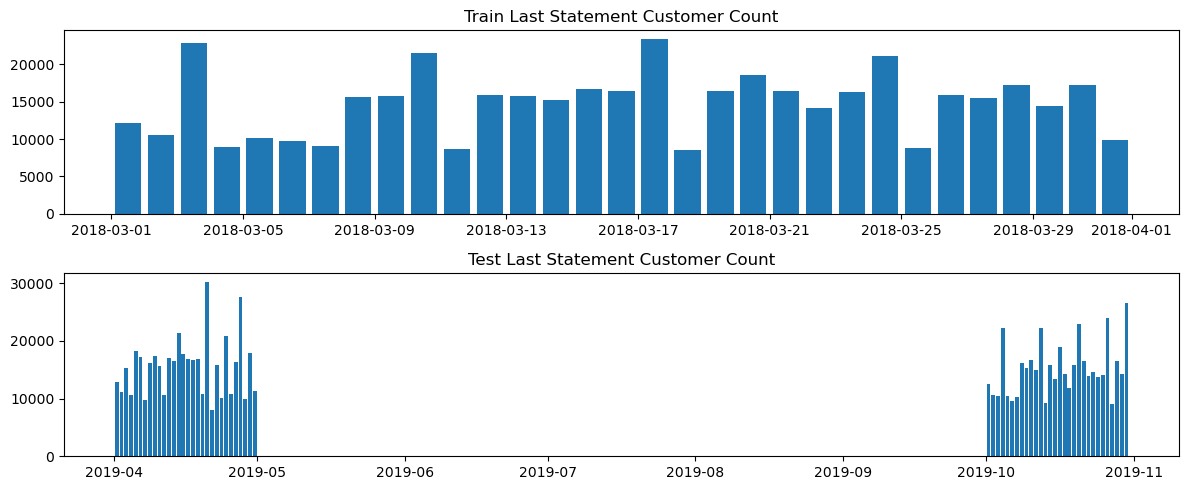

In [19]:
# plt.figure(figsize = (12,5))
fig , axes = plt.subplots(2,1,figsize = (12,5))
axes = axes.flatten()
axes[0].hist(traincustomer_dates['max'] , bins = pd.date_range('2018-03-01','2018-04-01',freq = 'd') , rwidth = 0.8)
axes[0].set_title('Train Last Statement Customer Count')


axes[1].hist(testcustomer_dates['max'] , bins = pd.date_range(testcustomer_dates['max'].min(),
                                                          testcustomer_dates['max'].max(),freq = 'd') , rwidth = 0.8)
axes[1].set_title('Test Last Statement Customer Count')

plt.tight_layout()
plt.show()



**CATEGORICAL FEATURES**

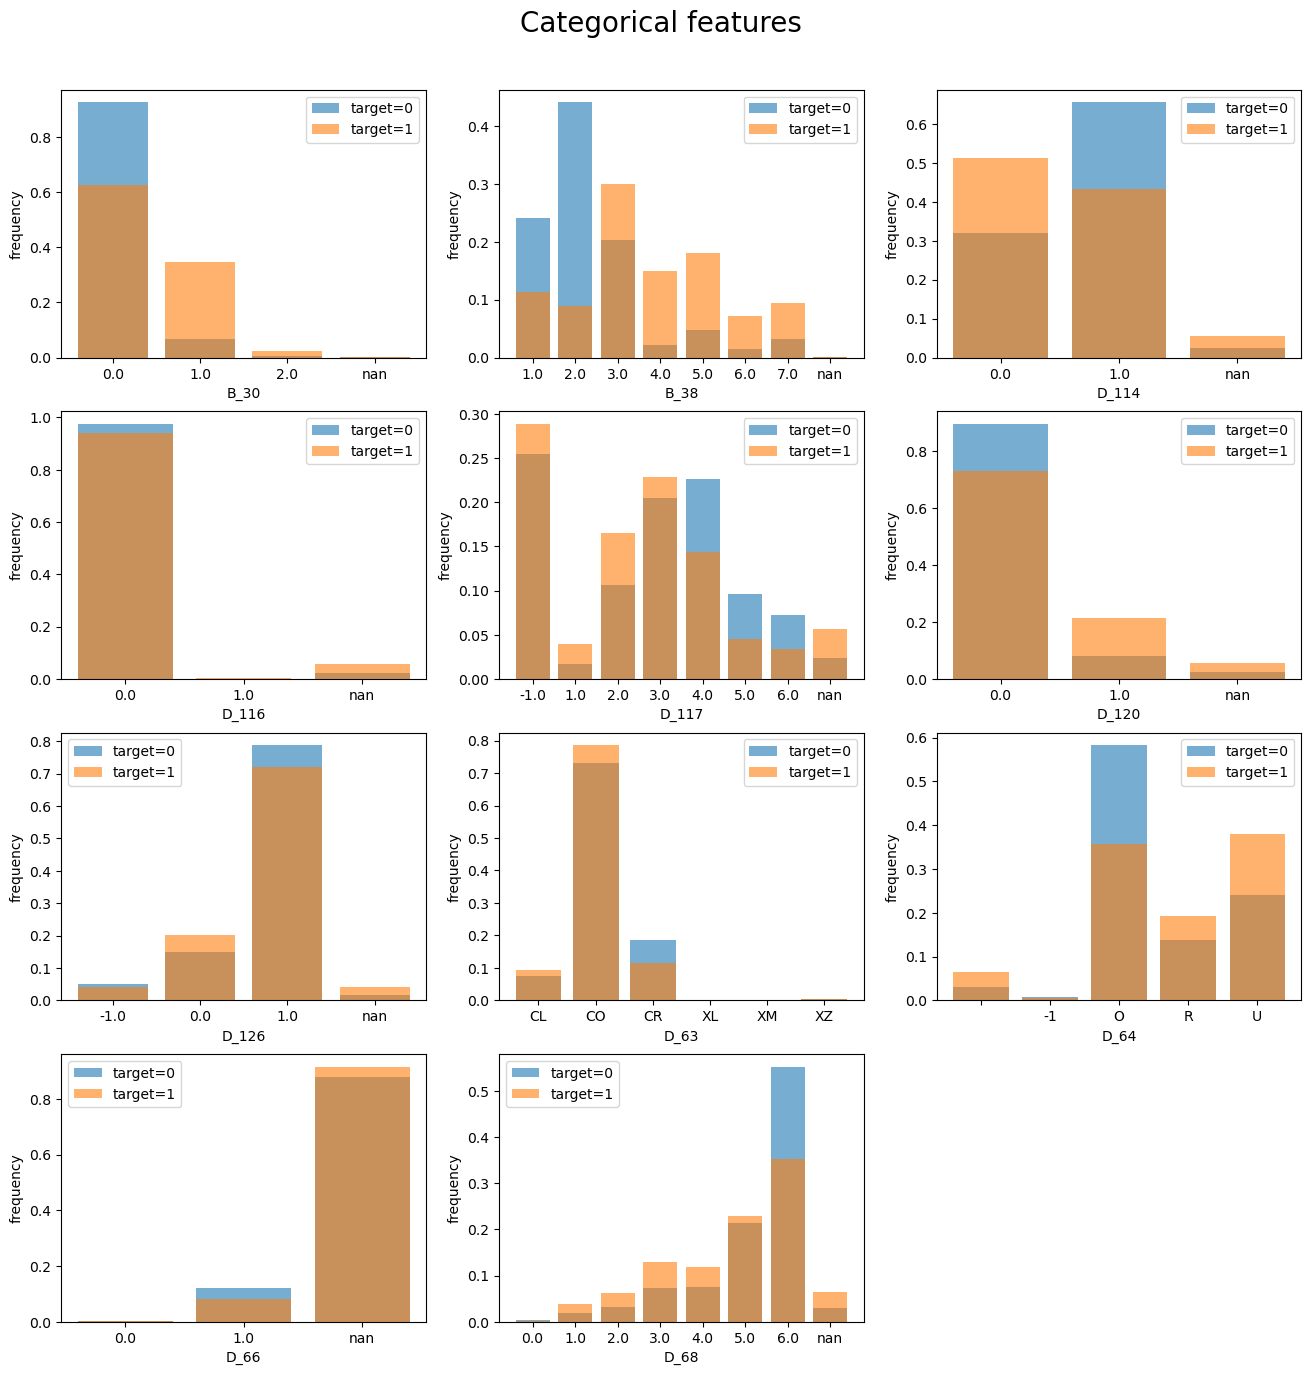

In [20]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
    plt.subplot(4, 3, i+1)
    temp = pd.DataFrame(traindata[f][traindata.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha = 0.6, label='target=0')
    temp = pd.DataFrame(traindata[f][traindata.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'],alpha = 0.6, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical features', fontsize=20, y=0.93)
plt.show()
del temp

Insight :

*1.There is something in the category that resides some information regarding target .*   
*2. Can be one-hot encoded.*

NUMERICAL FEATURES 

In [29]:
numeric_columns = traindata.select_dtypes(include = ['float16']).columns 
numeric_columns

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       'D_43',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=177)

In [32]:
len(numeric_columns)

177

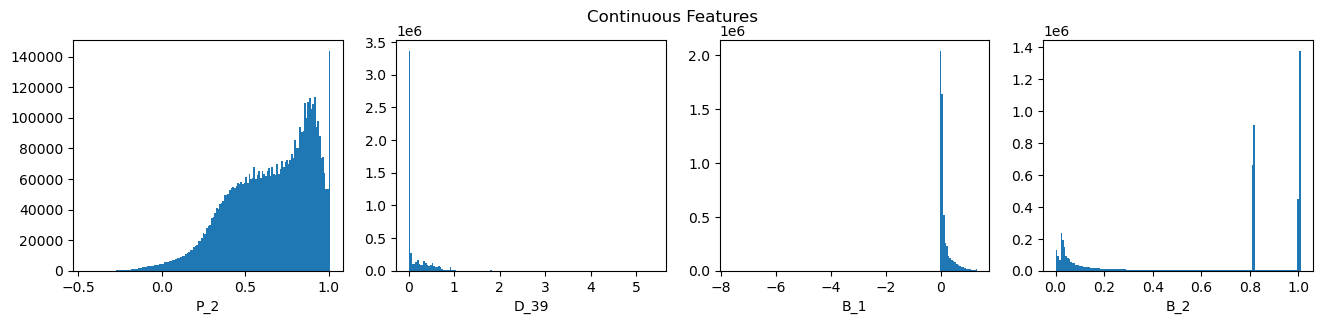

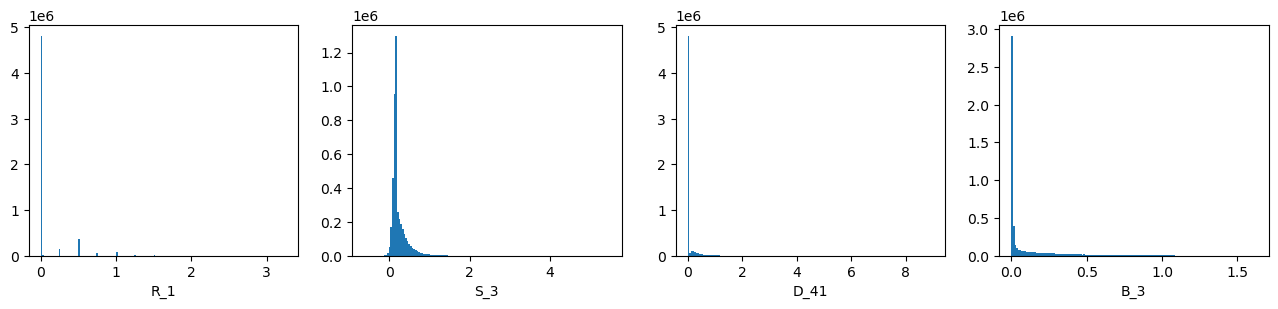

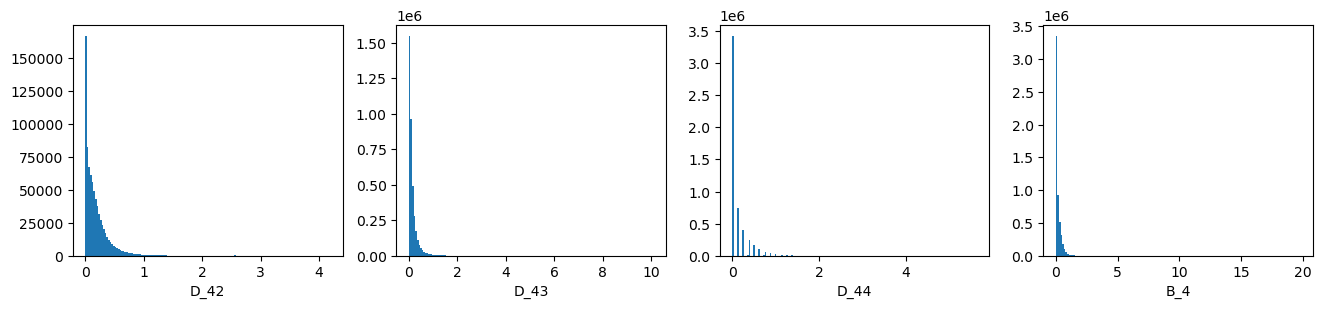

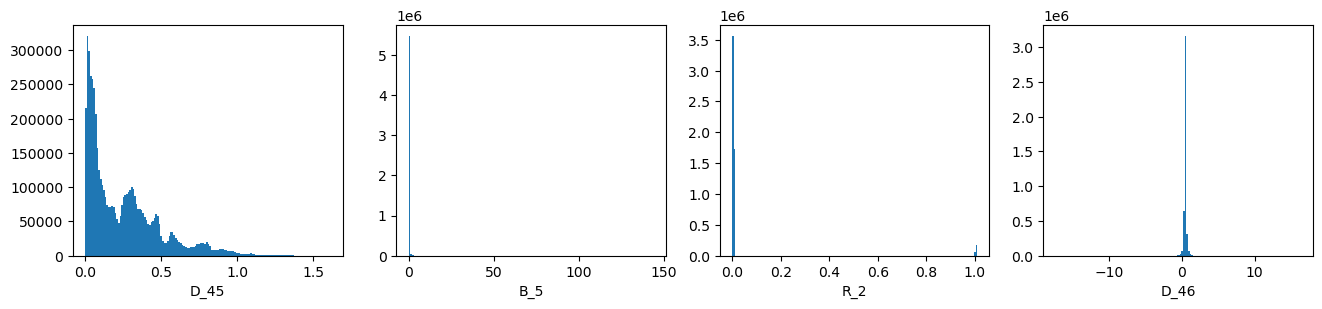

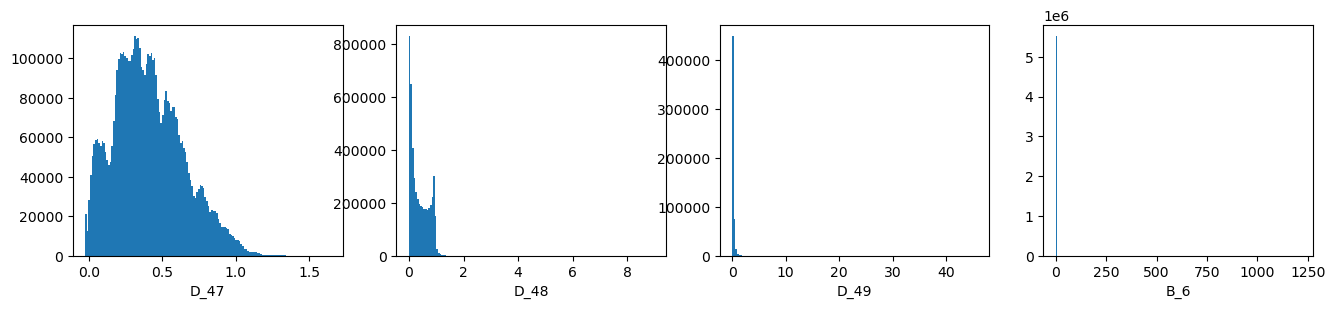

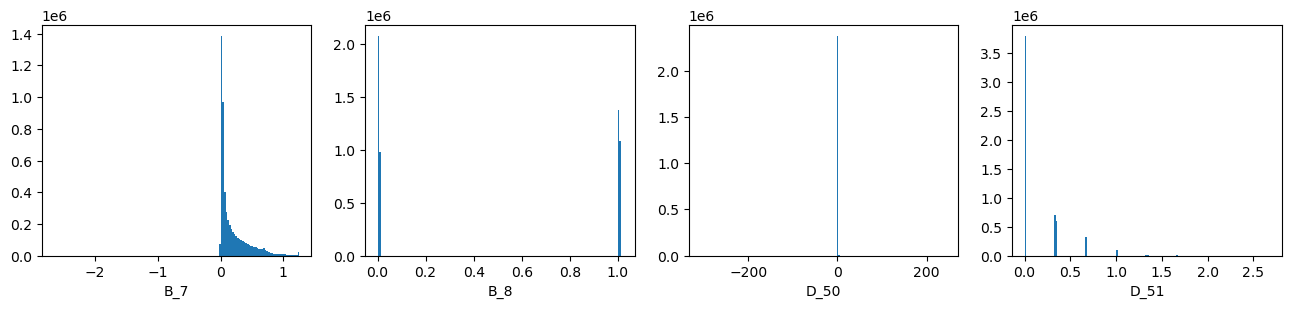

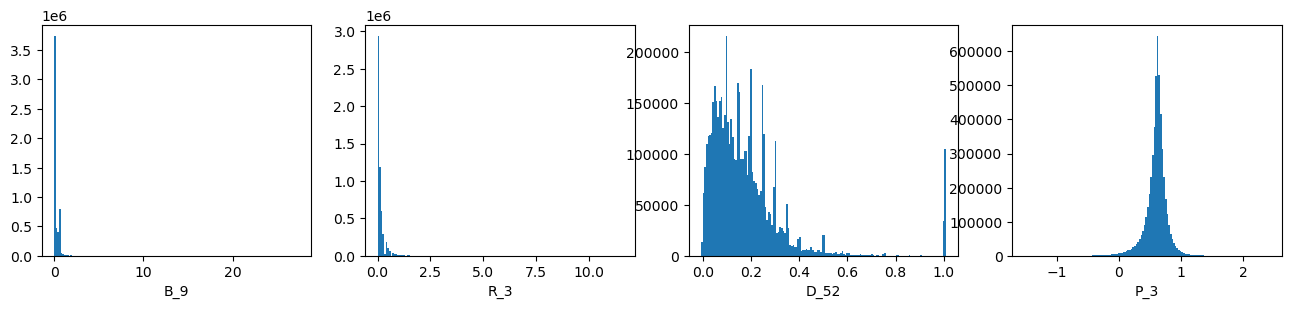

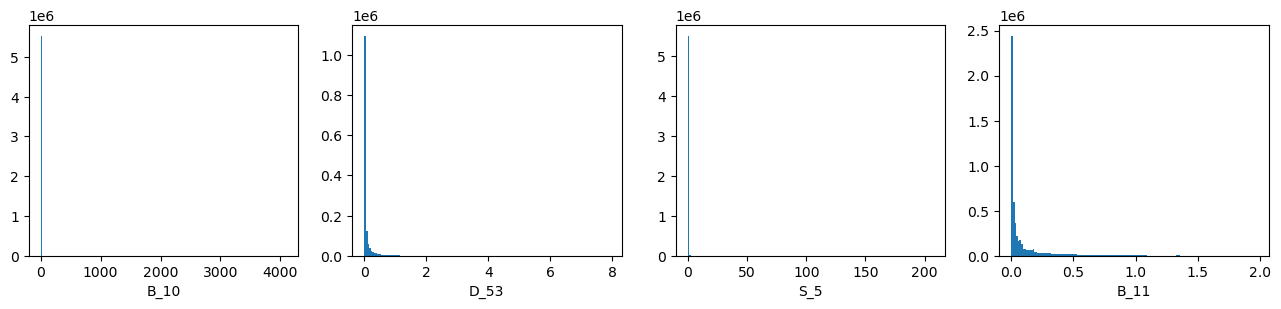

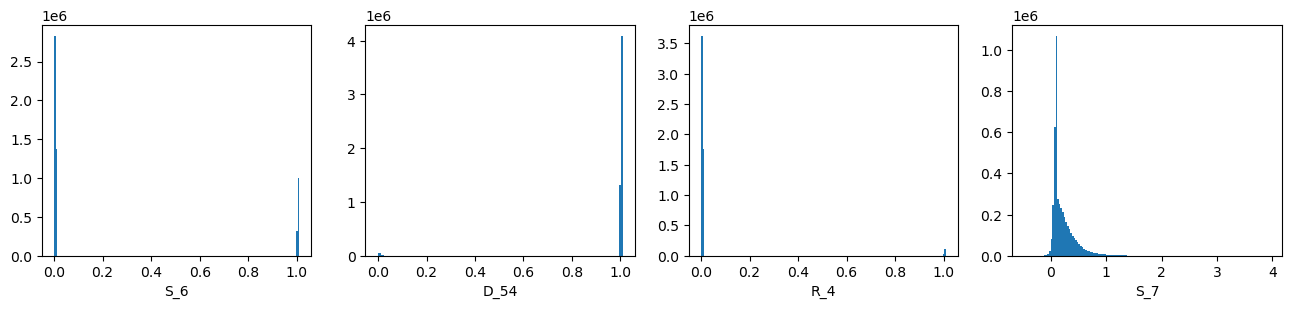

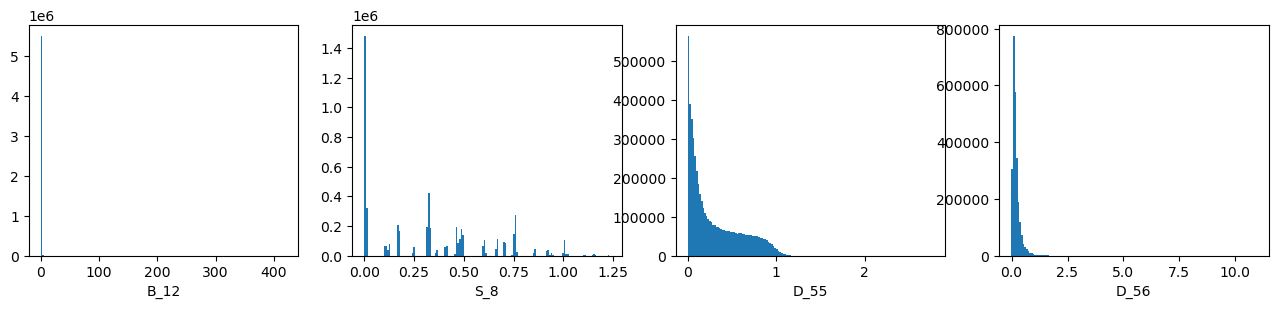

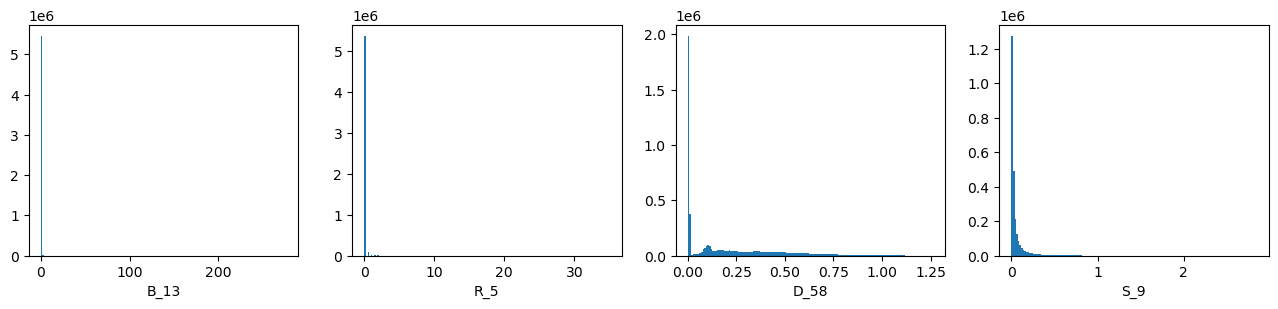

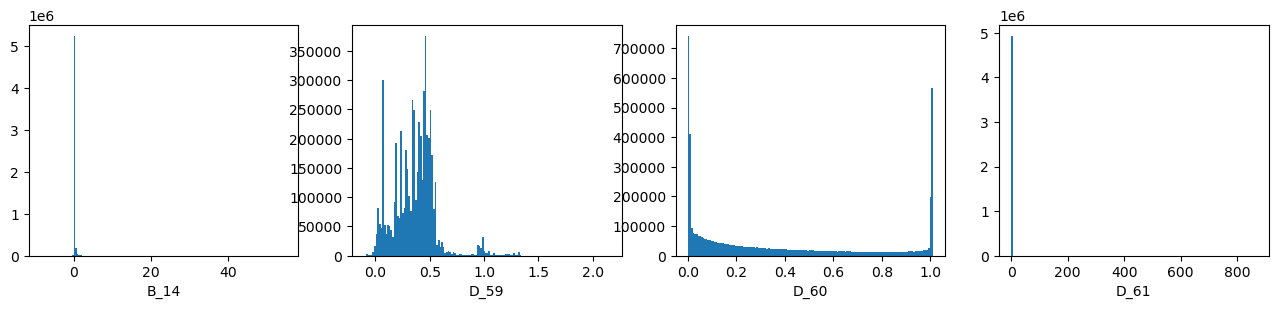

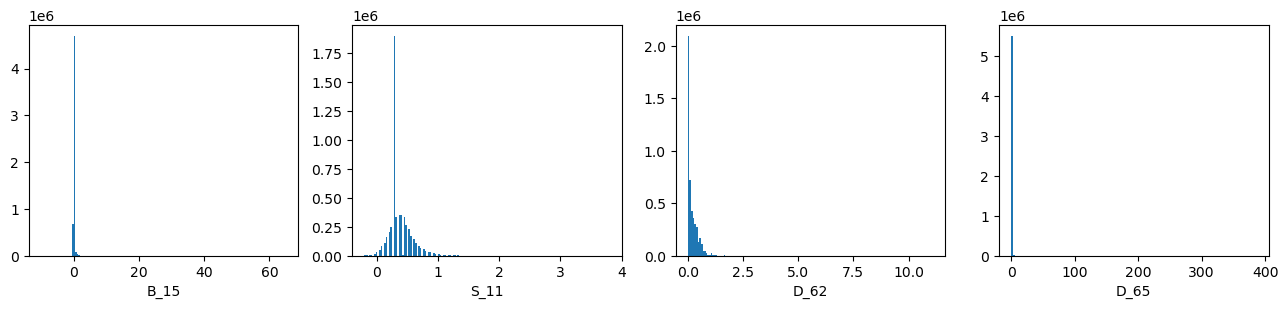

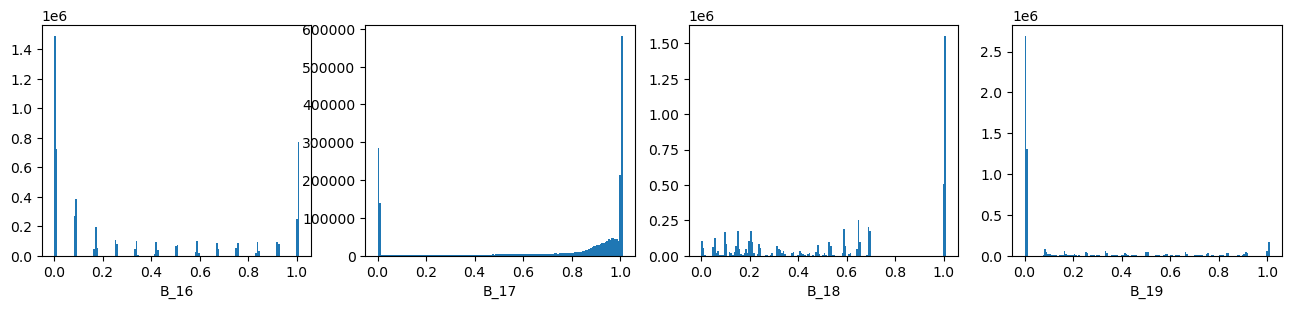

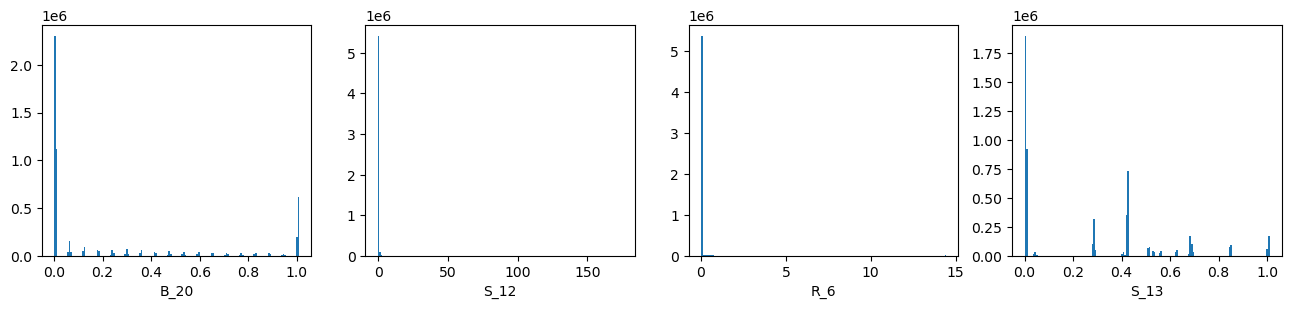

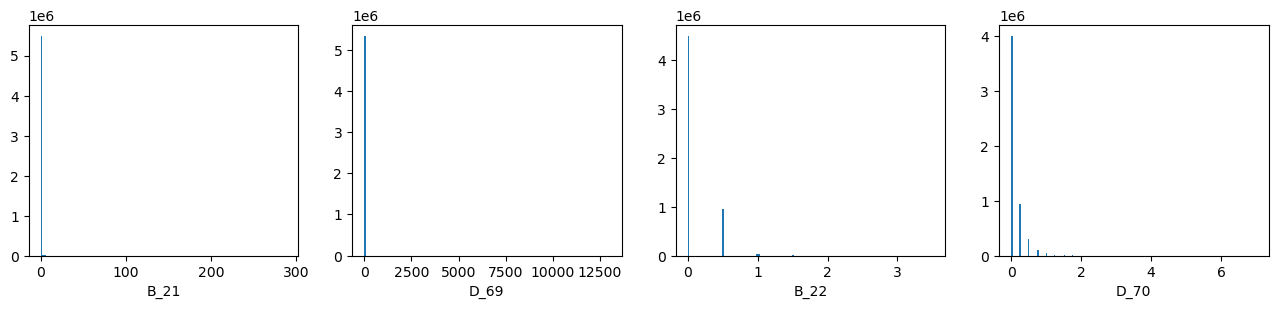

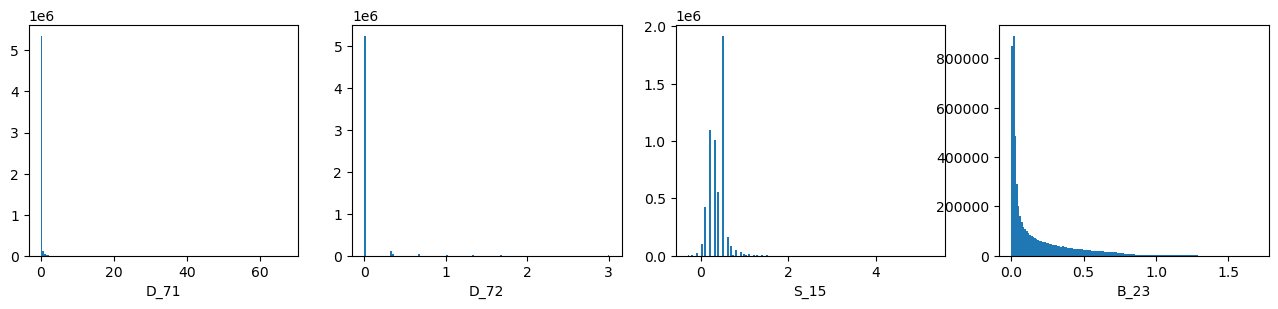

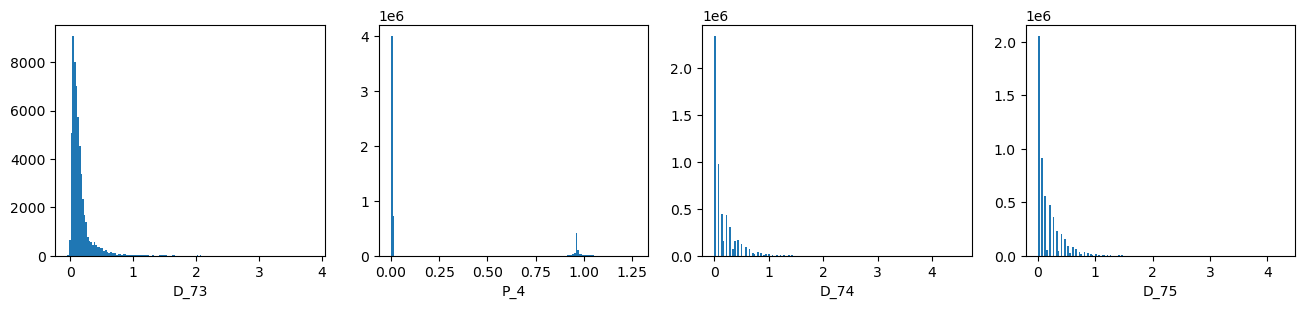

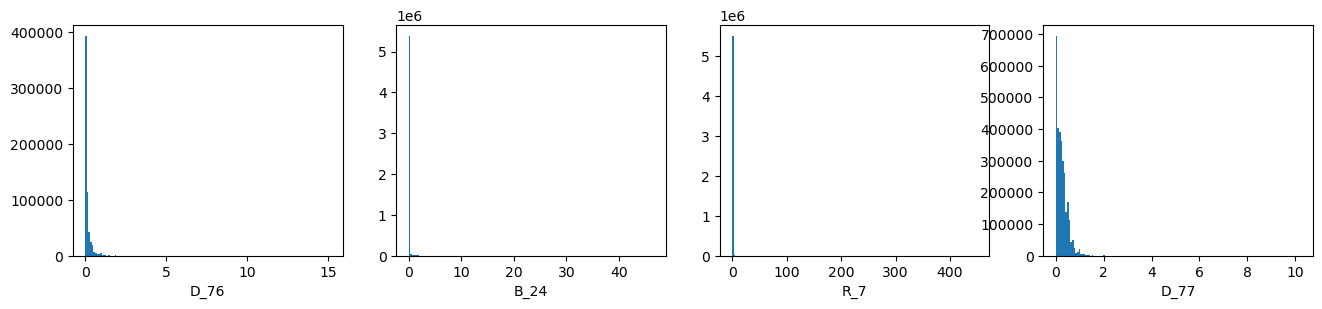

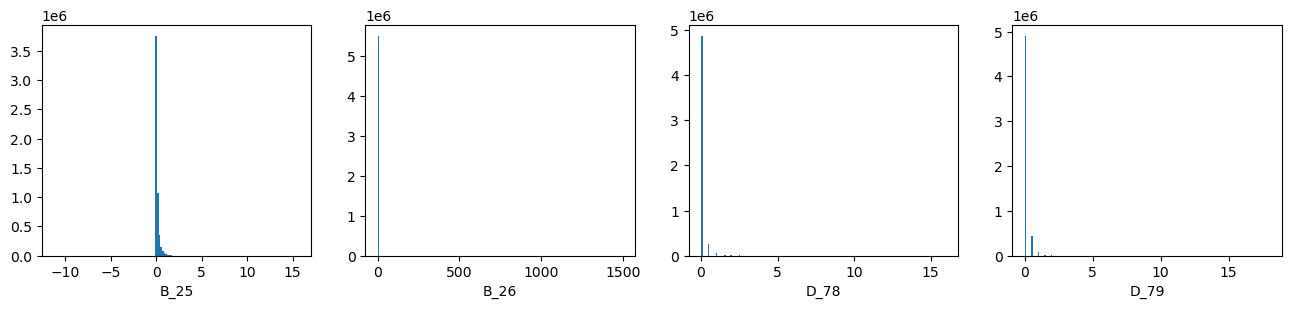

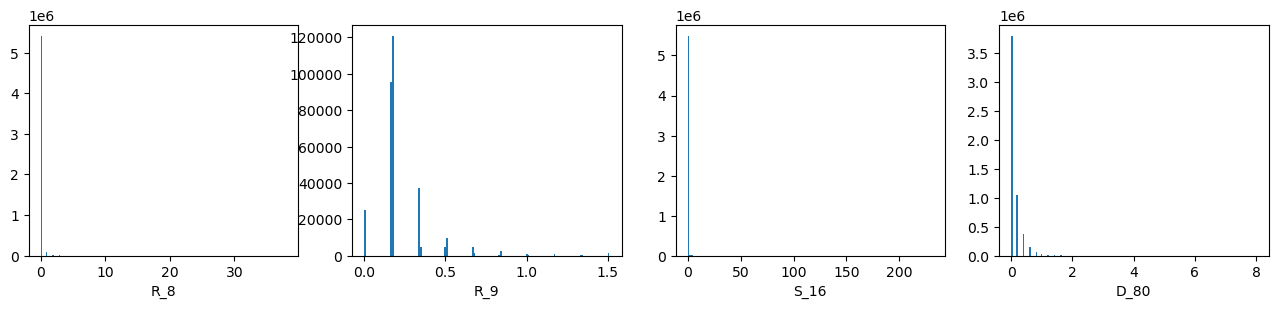

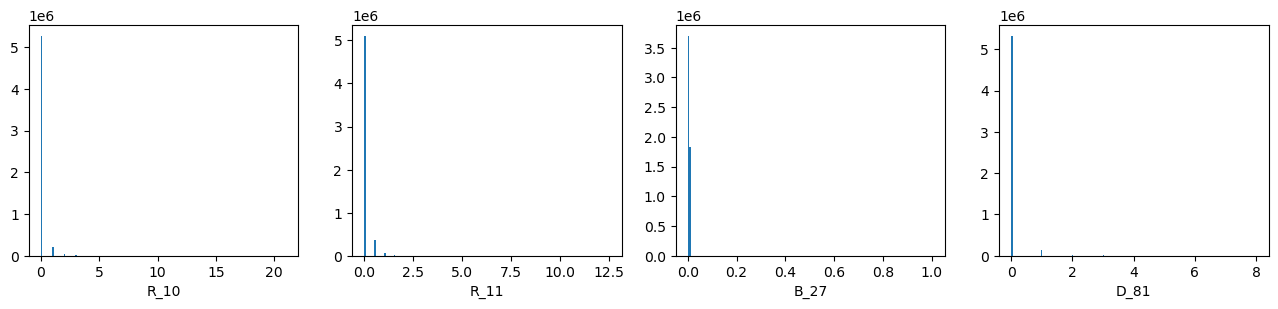

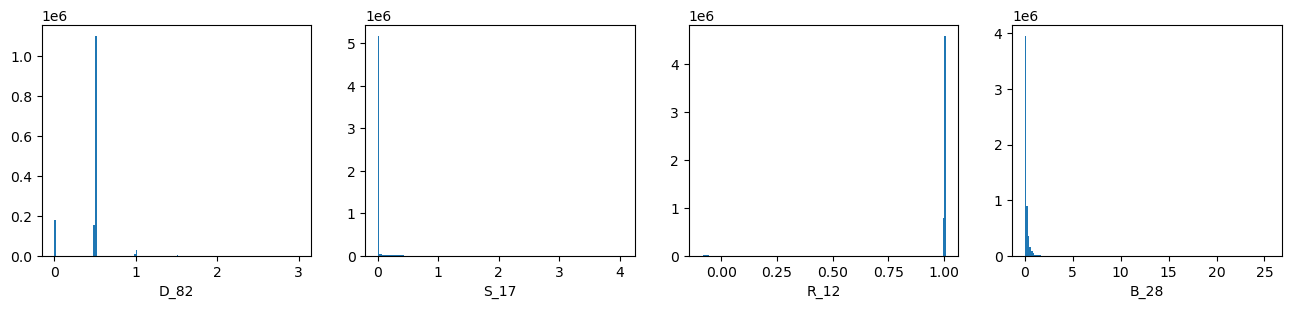

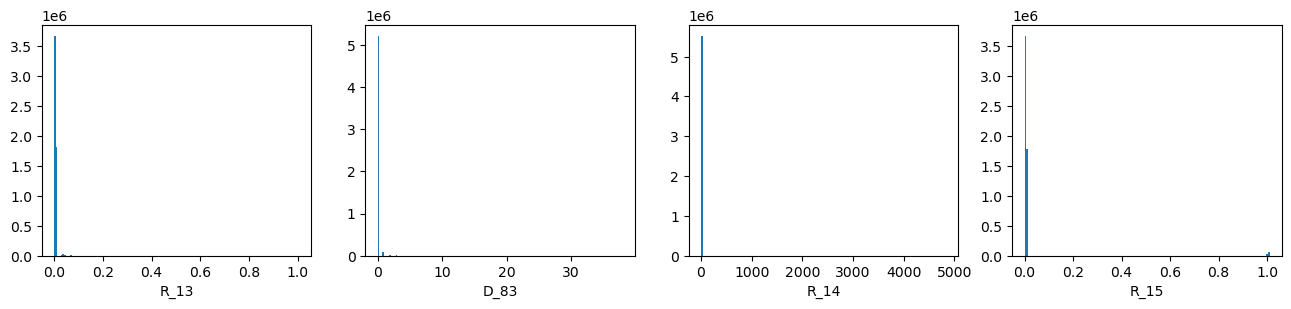

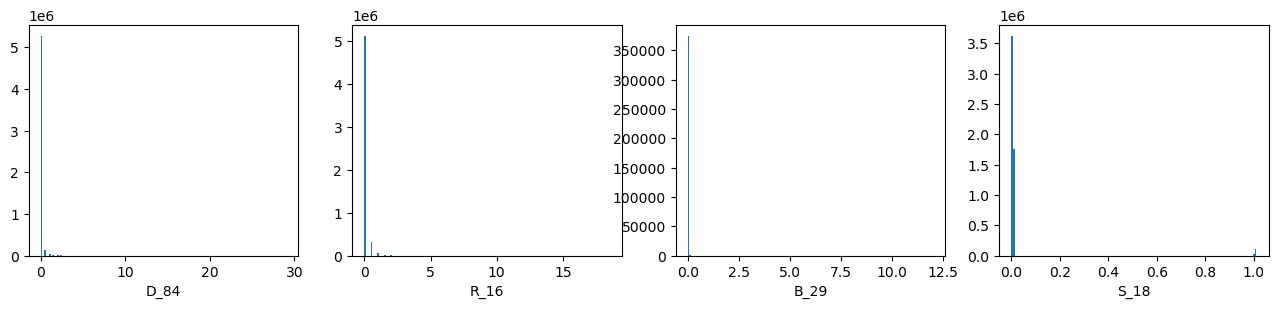

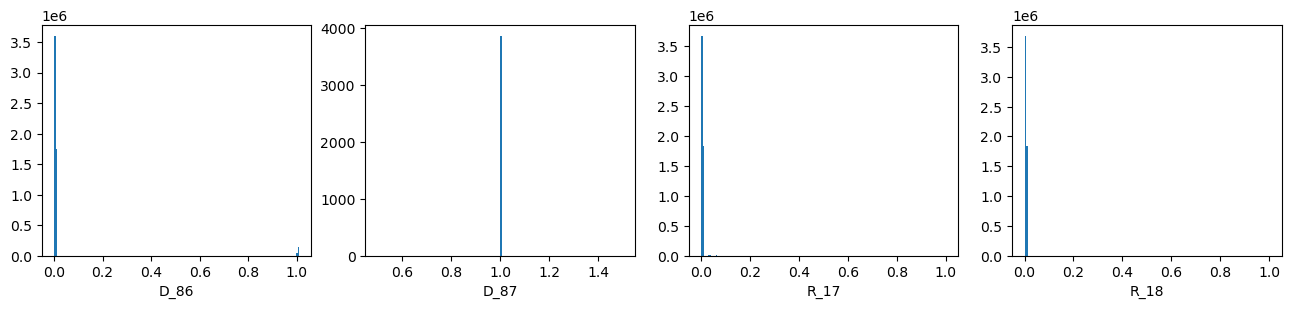

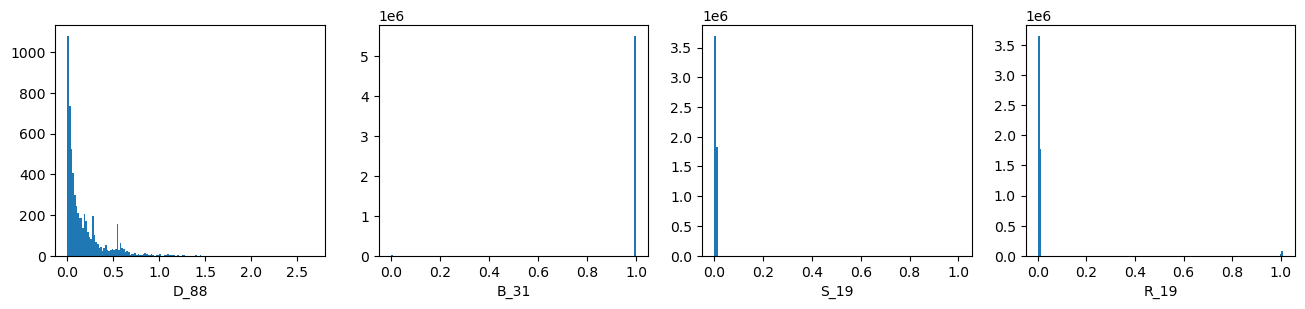

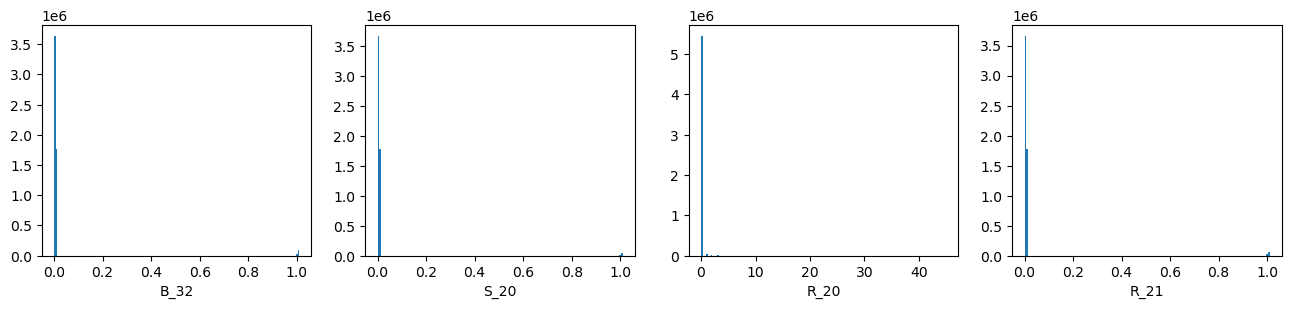

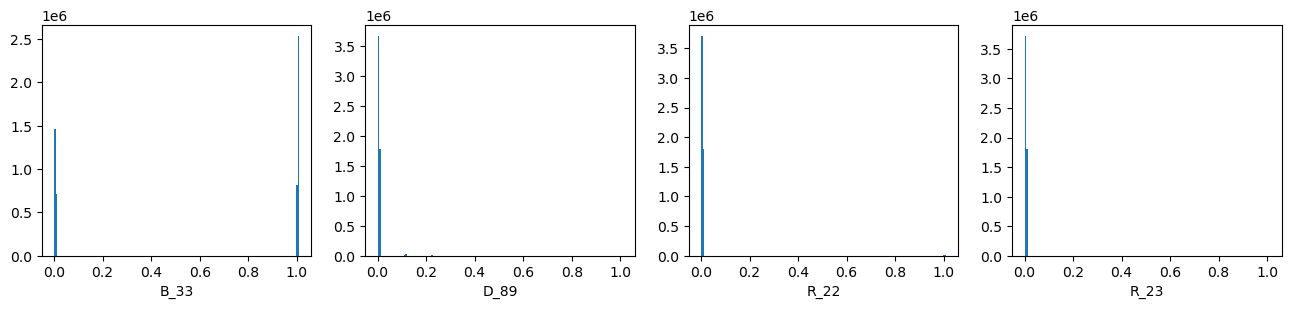

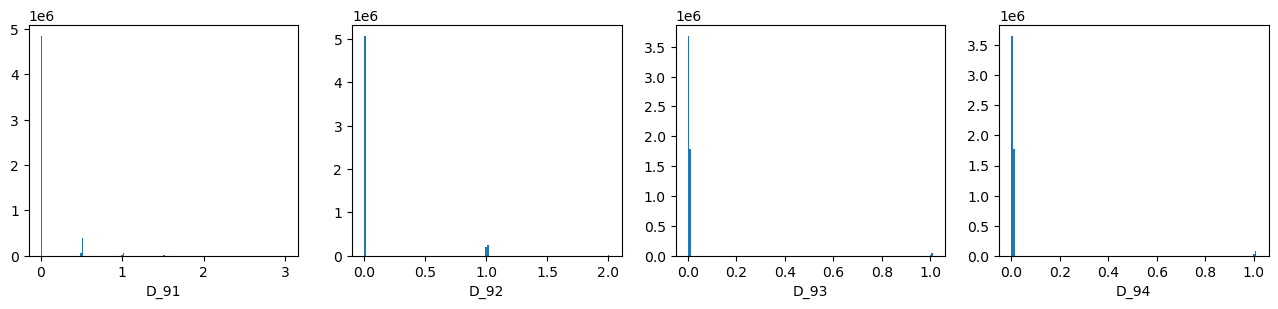

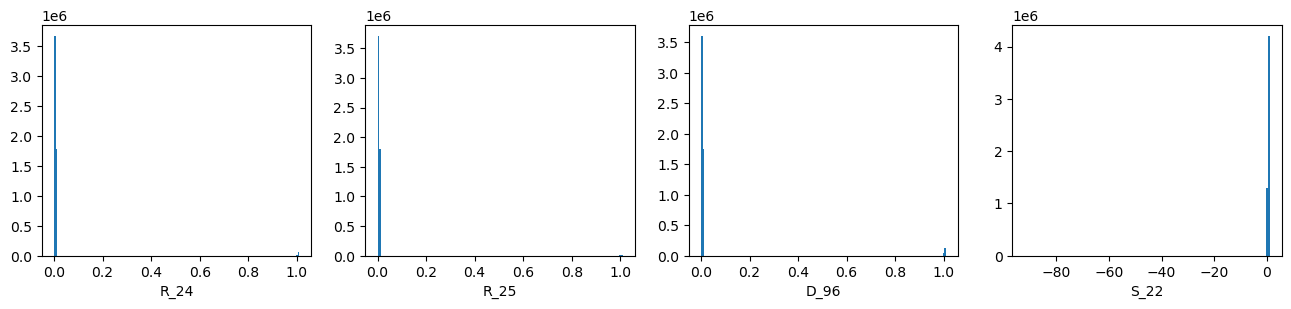

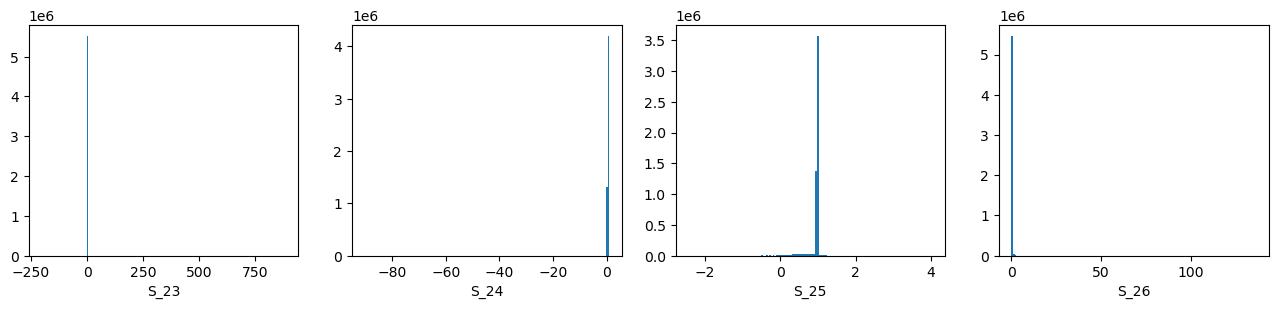

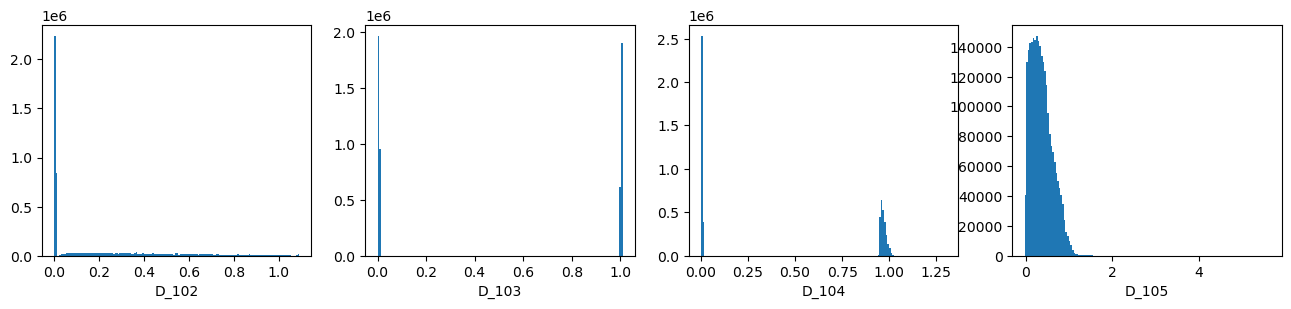

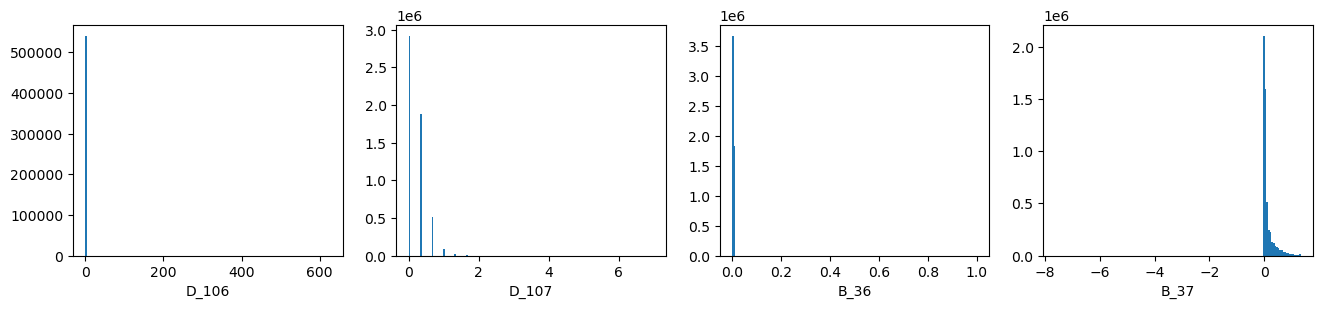

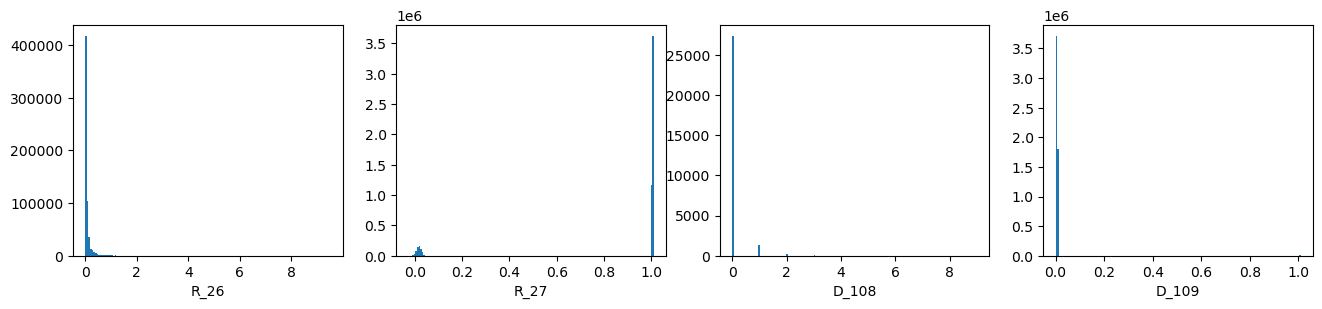

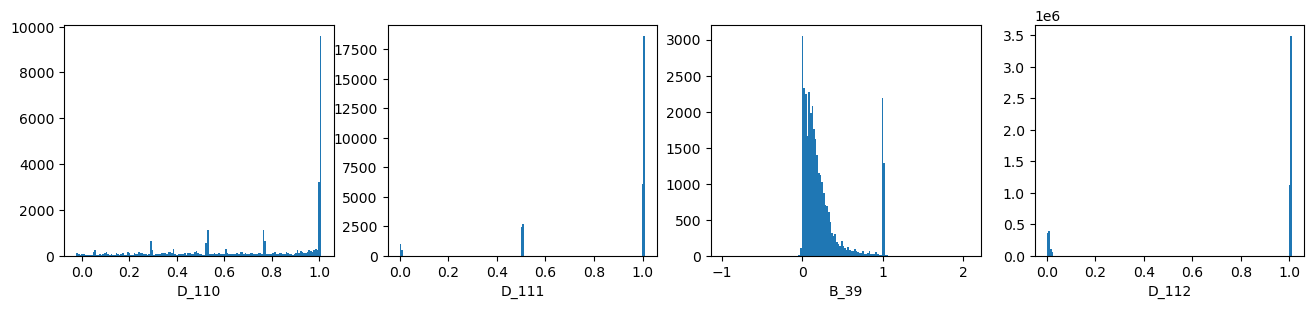

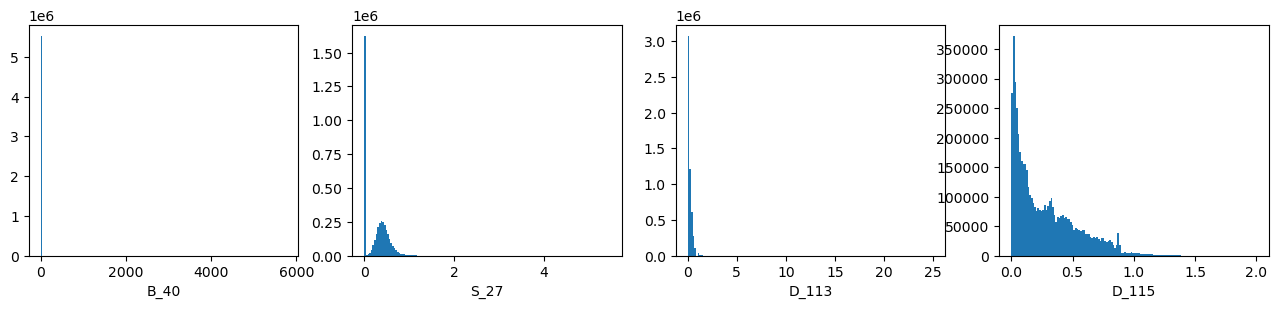

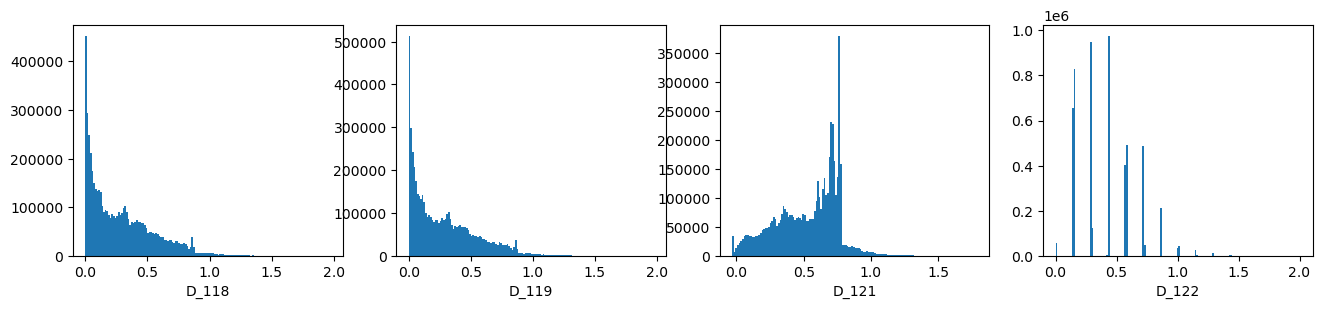

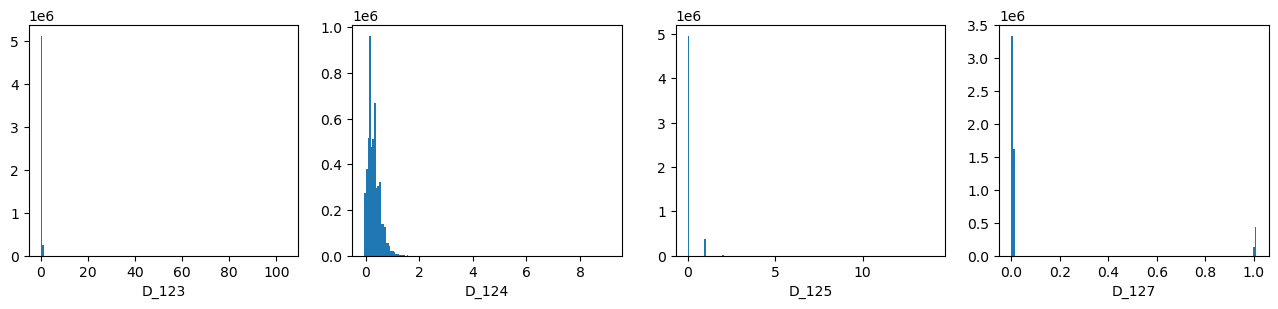

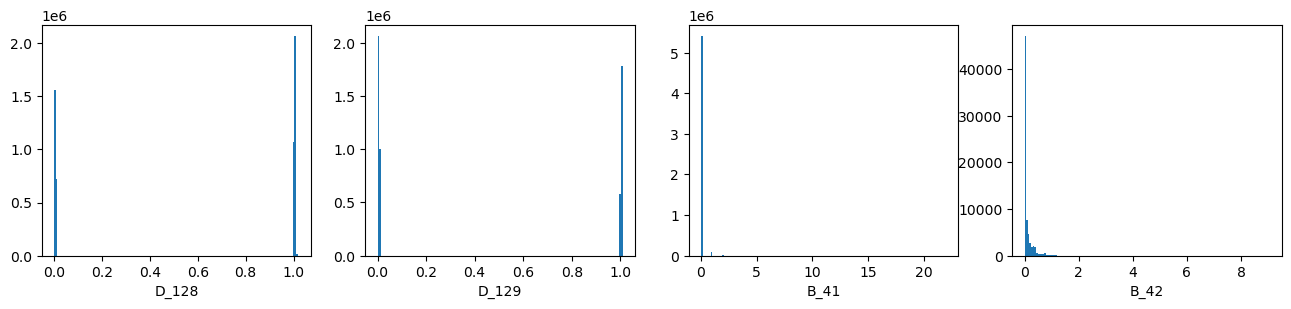

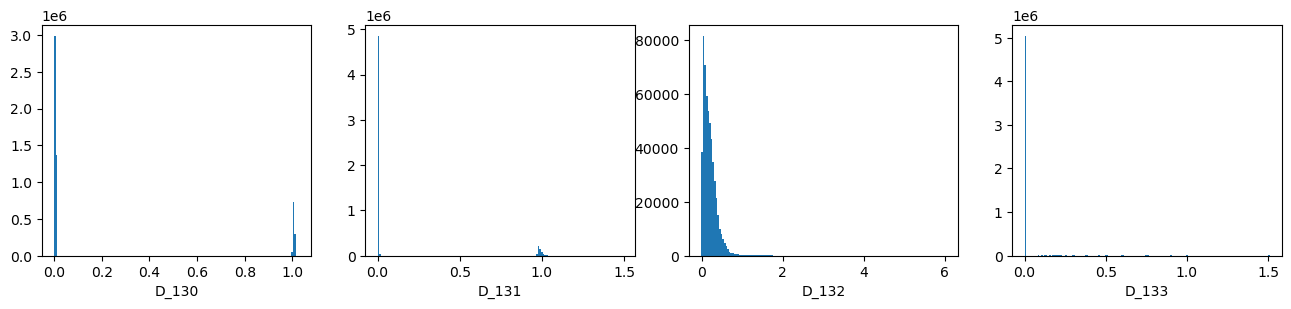

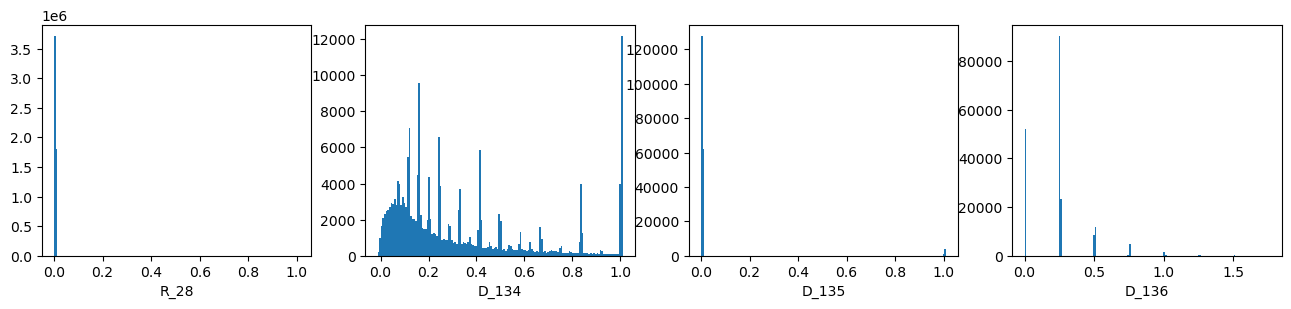

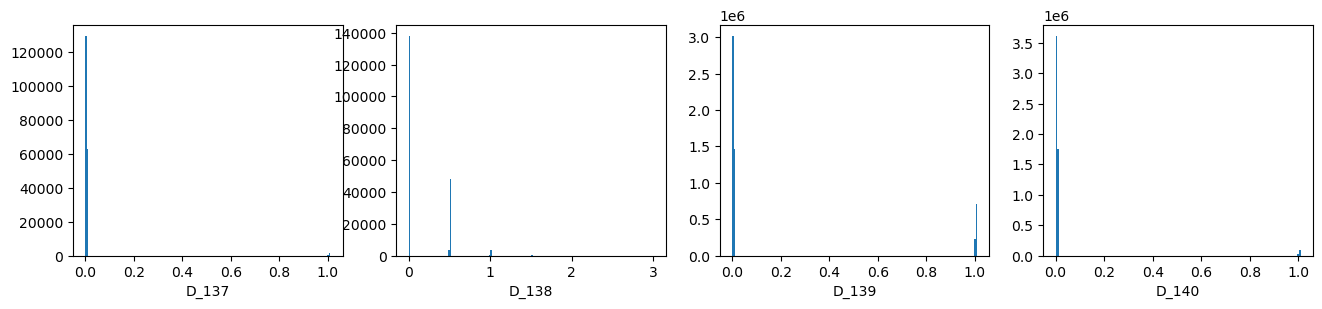

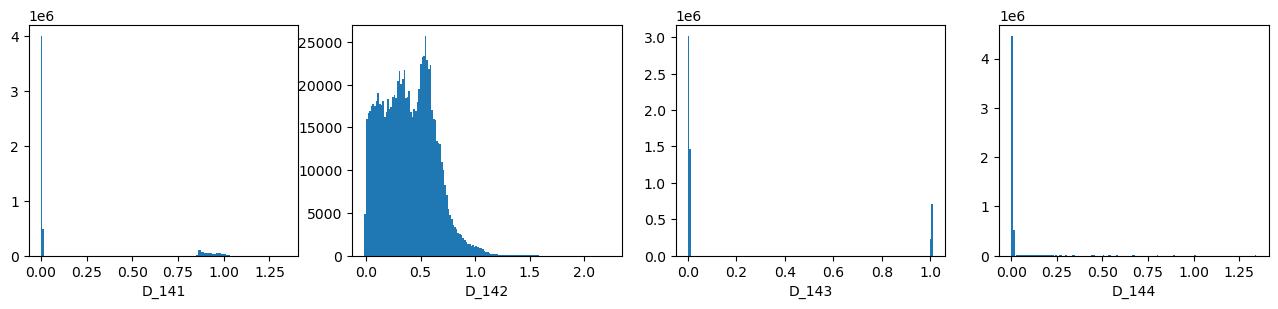

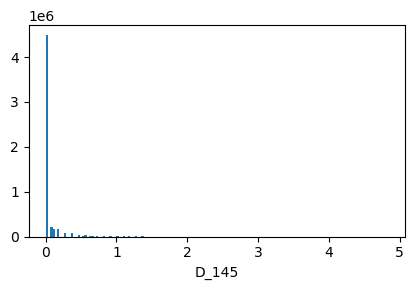

In [37]:
ncols = 4 

for i , col in enumerate(numeric_columns):
    if i%ncols == 0:
        if i>0 : plt.show()
        plt.figure(figsize = (16,3))
        if i == 0 : plt.suptitle('Continuous Features')
    plt.subplot(1,ncols , i%ncols+1)
    plt.hist(traindata[col] , bins = 150)
    plt.xlabel(col)

plt.tight_layout()
plt.show()
    

INSIGHTS :

1. Most of the numerical features seems to be discontinuous .
2. There is a uniform noise of [0,0.01]  added to the each discrete value . This requires much more memory(float32) as compare to (int8).
3. Removing the noise results in an surprising and interesting decrease in size.